In [1]:
! python --version

Python 3.10.11


In [2]:
! pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from typing import Optional

import abc
import numpy as np
import math
import pandas as pd

from sklearn.preprocessing import LabelEncoder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_path = 'drive/MyDrive/mts_lib_copy/'
# data_path = 'data/'
log_name = 'interactions.csv'
u_features_name = 'users.csv'
i_features_name = 'items.csv'

In [6]:
SEED = 123
K=10



# Рекомендательные системы

Обсудим задачи рекомендательных систем и особенности данных. 
Реализуем базовую рекомендательную систему и простейшую метрику.

# Датасет

Будем использовать датасет [MTS Library](https://www.kaggle.com/sharthz23/mts-library), содержащий данные об истории чтения книг пользователями МТС Библиотеки.

### Предобработка

In [7]:
df = pd.read_csv(data_path+log_name, sep=',')

In [8]:
assert df.shape[0] == 1533078

In [9]:
df.head(2)

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01


In [10]:
%%time
# конвертируем в дату
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# удаляем дубликаты, оставляя последний по времени
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

u_features = pd.read_csv(data_path+u_features_name, sep=',')
i_features = pd.read_csv(data_path+i_features_name, sep=',')
i_features.rename(columns={'id': 'item_id'}, inplace=True)

<timed exec>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


CPU times: user 686 ms, sys: 49.1 ms, total: 735 ms
Wall time: 847 ms


### Данные

In [11]:
u_features.head(2)

,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0


In [12]:
%%time
i_features.head(2)

CPU times: user 154 µs, sys: 0 ns, total: 154 µs
Wall time: 160 µs


,item_id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894


In [13]:
i_features.shape, i_features['item_id'].isin(df['item_id'].unique()).shape

((59599, 5), (59599,))

In [14]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print(f'Длина лога = {log.shape[0]},\nколичество пользователей = {log[user_id].nunique()},\nколичество объектов = {log[item_id].nunique()}')

In [15]:
get_log_info(df)

Длина лога = 1532998,
количество пользователей = 151600,
количество объектов = 59599


In [16]:
f"Количество рейтингов = {(~df['rating'].isna()).sum()}, что сильно меньше, чем количество данных о прогрессе чтения ({(~df['progress'].isna()).sum()})"


'Количество рейтингов = 285337, что сильно меньше, чем количество данных о прогрессе чтения (1532998)'

In [17]:
df.head(2)

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1437,97128,245669,1,NaN,2018-01-01


## Особенности данных в задаче рекомендаций
- всегда есть id пользователей/сессий и объектов
- часто есть timestamp (знаем об изменениях предпочтений пользователей во времени)
- есть оценка релевантности объектов для пользователей

In [18]:
df['progress'].min(), df['progress'].max(), df['rating'].min(), df['rating'].max()

(0, 100, 1.0, 5.0)

## Типы feedback
В нашем датасете есть progress - процент прочтения книги и rating - оценка, которую пользователь поставил. 
Это отличная иллюстрация для implicit и explicit feedback. Если пользователь поставил оценку, мы можем быть сильно уверены в том, насколько ему нравится книга. Но факт прочтения какой-то доли контента — тоже важный сигнал, и этой информации гораздо больше.

**Explicit**
- мало, но четко отражает предпочтения пользователя
- можно учить модели регрессии и ранжирования
- смещен в сторону "оценивает лучшая версия меня" (хоть мы и не говорим сегодня о вопросах психологии/этики)
- может быть двумодальное распределение (хочу похвалить или хочу поругать)

**Implicit**
- много
- разнородный
- часто не содержит негативного опыта/его надо извлекать на основе правил
- показывал реальные предпочтения пользователей

## Задачи

* предсказать для пользователя top-k релевантных объектов
* оценить релевантность выбранных пар пользователь-объект / переранжировать объекты для пользователя
* найти похожие объекты/похожих пользователей
* рекомендовать к сессии/корзине/товару

# EDA

## Распределение рейтинга и доли прочтения

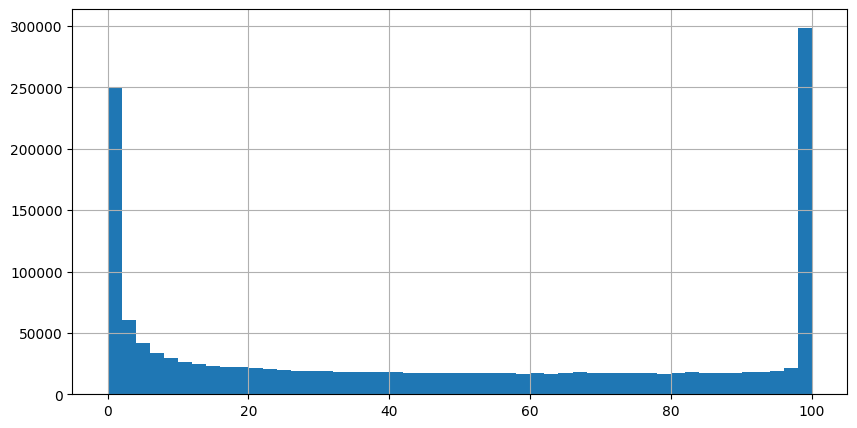

In [19]:
df['progress'].hist(bins=50, figsize=(10, 5));

Либо бросают быстро, либо дочитывают до конца

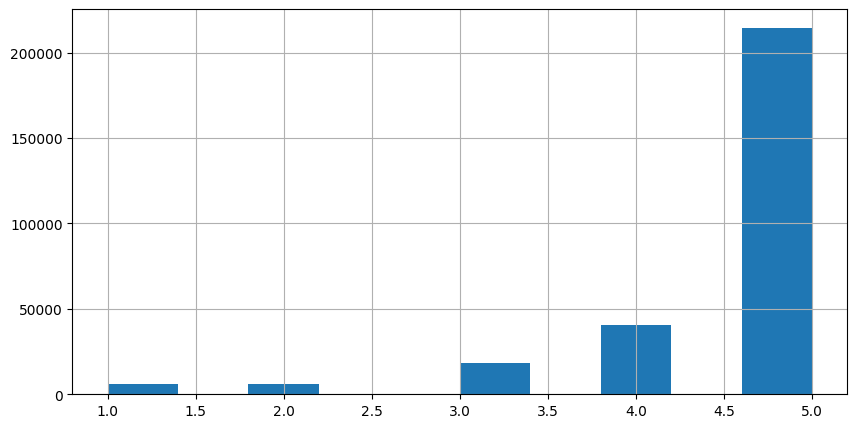

In [20]:
df['rating'].hist(bins=10, figsize=(10, 5));

Пользователи взаимодействуют с айтемами, которые им, скорее всего, понравятся, и предпочитают ставить оценки понравившимся, поэтому в реальных данных часто наблюдается смещение в сторону положительных оценок.

In [21]:
df['rating'].value_counts()

5.0    214703
4.0     40382
3.0     18273
1.0      6115
2.0      5864
Name: rating, dtype: int64

## Распределение числа прочтений у пользователя / книги

In [22]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=50, figsize=(10, 5), title=title)
    return grouped

count    151600.000000
mean         10.112124
std          20.922963
min           1.000000
5%            3.000000
25%           5.000000
50%           7.000000
75%          10.000000
95%          20.000000
max        2091.000000
Name: progress, dtype: float64


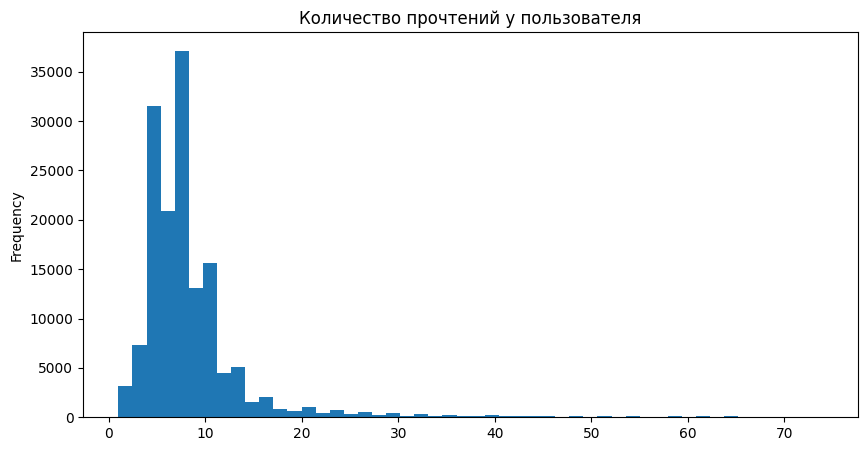

In [23]:
user_count = group_by_and_plot(df, group_by_name='user_id', rating_col_name='progress', quantile=0.99, title='Количество прочтений у пользователя')

count    59599.000000
mean        25.721875
std         60.665733
min          2.000000
5%           9.000000
25%         13.000000
50%         16.000000
75%         21.000000
95%         65.000000
max       6575.000000
Name: progress, dtype: float64


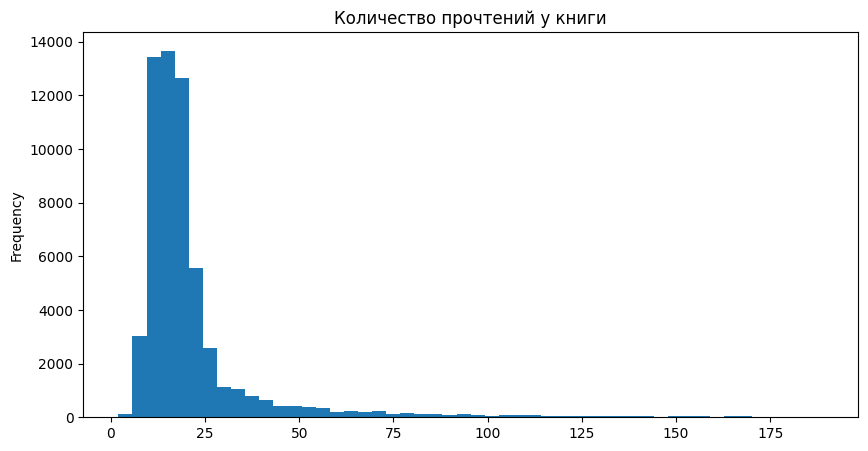

In [24]:
item_count = group_by_and_plot(df, group_by_name='item_id', rating_col_name='progress', quantile=0.99, title='Количество прочтений у книги')

Данные довольно плотные, у 95% пользователей более трех взаимодействий, у 95% книг более 9 прочтений

count    101885.000000
mean          2.800579
std          10.026988
min           1.000000
5%            1.000000
25%           1.000000
50%           1.000000
75%           2.000000
95%           5.000000
max         691.000000
Name: rating, dtype: float64


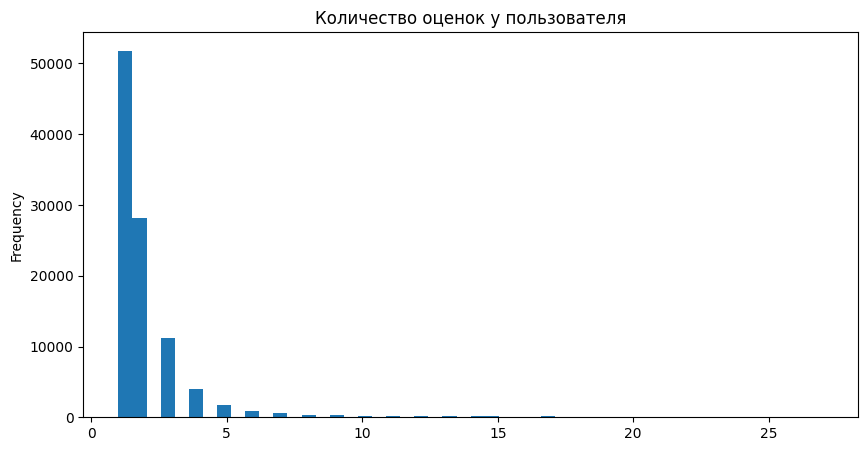

In [25]:
group_by_and_plot(df[~df['rating'].isna()], group_by_name='user_id', rating_col_name='rating', quantile=0.99, title='Количество оценок у пользователя');

Оценок гораздо меньше. Часто мы не хотим что-то рекомендовать человеку на основании одной оценки или строить матричные разложения/учить сетки на супер-разреженных данных, и поэтому используем implicit feedback.

<a id='filter'></a>
# 0 Фильтрация данных

Будем использовать историю чтения книг, а не оценки, так как этих данных больше и они могут лучше характеризовать актуальные предпочтения пользователей. 

Что такое релевантная книга по доле прочитанного? Прочитанная на 100%? А если на 60%?
Самый простой способ — отталкиваться от бизнес-требований и бизнес-метрик.


### Оставим взаимодействия с progress > 50

In [26]:
filtered_df = df[df['progress'] > 50]

In [27]:
get_log_info(filtered_df)

Длина лога = 712368,
количество пользователей = 143465,
количество объектов = 59560


### Удалим объекты и пользователей менее чем с 5 взаимодействиями

Облегчим себе жизнь и уменьшим размеры датасета. В индустрии и академии тоже так делают, так как качество коллаборативных моделей для пользователей и айтемов с небольшим числом взаимодействий с большой вероятностью будет низким. 

1) оставьте в filtered_df книги с 5 и более взаимодействиями, 

2) после этого оставьте в filtered_df пользователей с 5 и более взаимодействиями

In [28]:
item_counts = filtered_df.groupby('item_id')['user_id'].count()
pop_items = item_counts[item_counts > 4]
filtered_df = filtered_df[filtered_df['item_id'].isin(pop_items.index)]

In [29]:
user_counts = filtered_df.groupby('user_id')['item_id'].count()
pop_users = user_counts[user_counts > 4]
filtered_df = filtered_df[filtered_df['user_id'].isin(pop_users.index)].copy()

In [30]:
get_log_info(filtered_df)

Длина лога = 423599,
количество пользователей = 33875,
количество объектов = 50982


In [31]:
assert filtered_df.shape[0] == 423599
assert filtered_df['user_id'].nunique() == 33875

### Конвертация id

In [32]:
%%time
# конвертируем id пользователей и item-ов в подряд идущие номера
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
user_encoder.fit(filtered_df['user_id'])
item_encoder.fit(filtered_df['item_id'])

CPU times: user 51.9 ms, sys: 1 µs, total: 51.9 ms
Wall time: 54.9 ms


LabelEncoder()

In [33]:
i_features_filtered = i_features[i_features['item_id'].isin(filtered_df['item_id'].unique())].copy()
u_features_filtered = u_features[u_features['user_id'].isin(filtered_df['user_id'].unique())].copy()

In [34]:
%%time
filtered_df.loc[:, 'user_id'] = user_encoder.transform(filtered_df['user_id'])
filtered_df.loc[:, 'item_id'] = item_encoder.transform(filtered_df['item_id'])

CPU times: user 140 ms, sys: 123 µs, total: 140 ms
Wall time: 143 ms


In [35]:
%%time
i_features_filtered.loc[:, 'item_id'] = item_encoder.transform(i_features_filtered['item_id'])
u_features_filtered.loc[:, 'user_id'] = user_encoder.transform(u_features_filtered['user_id'])
# i_features_filtered.set_index('item_id', inplace=True)

CPU times: user 12.1 ms, sys: 12 µs, total: 12.1 ms
Wall time: 12.1 ms


In [38]:
TEST_BOOK = 36618
i_features_filtered[i_features_filtered['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017


In [39]:
TEST_USER = 4
u_features_filtered[u_features_filtered['user_id'] == TEST_USER]

,user_id,age,sex
19,4,18_24,0.0


# 1 Разбиение данных

Как построить локальную валидацию? 
Опять же, исходя из реальной задачи. В реальности у нас есть срез истории взаимодействия в прошлом и мы хотим предсказать предпочтения пользователей в будущем.
В статьях разных лет используются:
- случайное разбиение
- случайное внутри истории пользователя (k item-ов каждого пользователя в test)
- leave-one-out / leave-k-out  по времени
- time-based (например, взаимодействия в течение будущих 7 дней)

Почему плохо разбивать без учета timestamp? 

Реализуем time-based разбиение, оставим в test только активных пользователей и возьмем первые K взаимодействий.

In [40]:
%%html
<iframe src="https://drive.google.com/file/d/1L7dgH9lMYHBpxPASPJEUjm8U3_f9VrdQ/preview" width="640" height="480" allow="autoplay"></iframe>

Лучше не ограничиваться одним сплитом, а выполнять кросс-валидацию, так как поведение пользователей, а с ним и метрики, могут меняться в зависимости от времени, дня недели, погодных условий и других внешних факторов.

## Разобьем датасет на train и test по времени, взяв 20% наиболее свежих взаимодействий в test

In [41]:
train_by_date = filtered_df[filtered_df['start_date'] <= filtered_df['start_date'].quantile(0.8)]
test_by_date = filtered_df[filtered_df['start_date'] > filtered_df['start_date'].quantile(0.8)]

In [42]:
assert train_by_date.shape[0] == 339083
assert test_by_date.shape[0] == 84516

## Оставим в test только пользователей, у которых в test 5 и более взаимодействий и возьмем первые 5 из них

In [43]:
counts_in_test = test_by_date.groupby('user_id')['item_id'].count()
test_by_date = test_by_date[test_by_date['user_id'].isin(counts_in_test[counts_in_test > 4].index)].copy()
test_by_date['rank'] = test_by_date.groupby('user_id')['start_date'].rank(method="first", ascending=True)
test_by_date = test_by_date[test_by_date['rank'] <= 5].drop(columns=['rank'])

# удалим холодных пользователей
test_by_date = test_by_date[test_by_date['user_id'].isin(train_by_date['user_id'].unique())]
test_by_date_users = test_by_date['user_id'].drop_duplicates()

In [44]:
assert test_by_date.shape[0] == 14995

In [45]:
get_log_info(train_by_date)

Длина лога = 339083,
количество пользователей = 33685,
количество объектов = 49664


In [46]:
get_log_info(test_by_date)

Длина лога = 14995,
количество пользователей = 2999,
количество объектов = 7635


# 2 Первая модель — рекомендуем популярное

Самый простой рекомендатель — модель, которая будет рекомендовать популярные книги (книги, которые чаще всего читали). Построим такую модель.

In [47]:
popularity = train_by_date.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
popularity /= train_by_date['user_id'].nunique()

In [48]:
assert math.isclose(popularity[14267], 0.016951, abs_tol=1e-6)

In [49]:
pd.DataFrame(popularity).merge(i_features_filtered, on='item_id').head(10)

,item_id,popularity,title,genres,authors,year
0,14267,0.016951,Зулейха открывает глаза,Современная русская литература,Гузель Яхина,2015
1,50597,0.014547,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05
2,42084,0.013626,После,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014
3,19385,0.013626,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007
4,39972,0.011340,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
5,17922,0.011281,После ссоры,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014
6,43572,0.011222,Чистовик,Научная фантастика,Сергей Лукьяненко,2007
7,25325,0.009351,Пятьдесят оттенков серого,"Эротические романы,Зарубежные любовные романы",Э. Л. Джеймс,2012
8,43119,0.009084,Струны волшебства. Книга первая. Страшные сказ...,"Героическое фэнтези,Книги про волшебников",Милена Завойчинская,2018
9,15722,0.009025,"Сила подсознания, или Как изменить жизнь за 4 ...","Практическая эзотерика,Эзотерика / оккультизм,...",Джо Диспенза,2013


### Первая книга — Зулейха открывает глаза? Поздравляю, вы написали первую рекомендательную систему!

Что не так?
- Мы все-таки хотим предсказывать для пользователя, и хотим отфильтровать уже прочитанные им книги
- Хотим получить predict для пользователей в виде датафрейма с колонками `user_id - item_id - relevance`
- Хотим уметь получать нужное количество рекомендаций для каждого пользователя

Поэтому сделаем базовый класс для рекомендателя, и будем наследовать от него наши алгоритмы.

# Класс ParentModel

Давайте разберемся
- как работают leave_top_k и _filter_seen
- что делает predict

Функционал Parent Model вдохновлен кодом нашей разработки - библиотеки для рекомендательных систем [RePlay](https://github.com/sb-ai-lab/RePlay). В самой библиотеке можно найти реализацию популярных метрик, алгоритмов и сплиттеров, а в [документации](https://sb-ai-lab.github.io/RePlay/pages/modules/models.html) к ней - необходимые пояснения и формулы.


In [50]:
from copy import deepcopy

In [51]:
def leave_top_k(pred: pd.DataFrame, 
                 k: int,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred


def filter_seen_items(log: pd.DataFrame, 
                 pred: pd.DataFrame) -> pd.DataFrame:
    """
    filter pairs `user-item` present in log out of pred
    """
    log_filtered = log[log['user_id'].isin(pred['user_id'].unique())]
    pred = pred.merge(log_filtered[['user_id', 'item_id']].drop_duplicates(), 
                                on=['user_id', 'item_id'], 
                                how='outer', 
                                indicator = True)
    return pred[pred['_merge'] == 'left_only'].drop(columns=['_merge'])


class ParentModel:
    @abc.abstractmethod
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None):
        """
        fit recommender
        
        Parameters
        ----------
        log : pandas dataframe with columns [user_id, item_id, timestamp, relevance]
        user_features : pandas dataframe with column `user_id` and features columns
        item_features : pandas dataframe with column `item_id` and features columns

        Returns
        -------
        
        """
    
    
    def predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen: bool = True) -> pd.DataFrame:
        """
        predict with fitted model, filter seen and crop to top-k for each user
        
        Parameters
        ----------
        log: pandas dataframe with columns [user_id, item_id, timestamp, relevance]
            used to filter seen and to make predictions by some models
        users: user ids to recommend for
        k: number of recommendations for each user
        user_features: pandas dataframe with column `user_id` and features columns
        item_features: pandas dataframe with column `item_id` and features columns
        filter_seen: if True, items present in user history are filtered from predictions

        Returns
        -------
        pandas dataframe with columns [user_id, item_id, relevance] 
            top-k recommended items for each user from `users`.
        """
        
        # overhead
        max_items_in_train = log.groupby('user_id')[['item_id']].count().max()[0] if filter_seen else 0
        
        pred = self._predict(
            log=log,
            users=users, 
            k=max_items_in_train+k,
            user_features=user_features, 
            item_features=item_features,
            filter_seen=filter_seen)
        if filter_seen:
            pred = filter_seen_items(log, pred)
            
        return leave_top_k(pred, k)
    
    
    @abc.abstractmethod    
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        """
        predict with fitted model
        """

## Модель для рекомендаций популярного
relevance = популярность книги, число пользователей, читавших книгу, деленное на общее число пользователей

In [52]:
class PopularModel(ParentModel):
    items_popularity: pd.DataFrame
        
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'PopularModel':
        
        self.items_popularity = log.groupby('item_id')['user_id'].count().sort_values(ascending=False).rename('popularity') / log['user_id'].nunique()
        return self
        
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:

        users_to_join = pd.DataFrame(users)
        users_to_join['key'] = 0
        pred = pd.DataFrame({'item_id': self.items_popularity[:k].index.to_list(),
                     'relevance': self.items_popularity[:k].values})
        pred['key'] = 0
        return users_to_join.merge(pred, on='key', how='outer').drop(columns=['key']).reset_index(drop=True)


In [53]:
%%time
rec = PopularModel()
rec.fit(train_by_date)

CPU times: user 18.4 ms, sys: 66 µs, total: 18.5 ms
Wall time: 18.6 ms


In [54]:
%%time
pred = rec.predict(log=train_by_date, users=test_by_date_users, k=K, filter_seen=True)

CPU times: user 865 ms, sys: 149 ms, total: 1.01 s
Wall time: 1.01 s


In [55]:
pred.head(11)

,user_id,item_id,relevance
0,24036,14267,0.016951
1,24036,50597,0.014547
2,24036,42084,0.013626
3,24036,19385,0.013626
4,24036,39972,0.011340
5,24036,17922,0.011281
6,24036,43572,0.011222
7,24036,25325,0.009351
8,24036,43119,0.009084
9,24036,15722,0.009025


In [56]:
assert pred.shape[0] == test_by_date_users.shape[0] * K
assert (pred.groupby('user_id')['item_id'].count() == K).all()
assert pred['item_id'].nunique() > K

## Улучшение рекомендаций популярного
Мы рекомендовали популярное, это максимально простая модель, у которой могут быть простые улучшения. Например, можно подобрать период, за который берутся данные или учитывать более "свежие" взаимодействия с большим весом или сэмплировать рекомендации с вероятностями, пропорциональными популярности, чтобы достичь большего разнообразия.

# Метрики

Как понять, что понравится пользователю? Для максимальной достоверности — порекомендовать и посмотреть на его поведение (кликнет/купит/посмотрит ли рекомендованные айтемы).

Но жизнь устроена по-другому!

A/B-тестирование - честно, но:
- дорого
- сложно
- рискованно
- не походит для прототипирования.

A/B на синтетических данных:
- не научились пока качественно моделировать поведение пользователей

Поэтому в первую очередь для оценки качества применяются offline эксперименты, и измеряют offline-метрики.

Метрики качества:
- регрессионные метрики (RMSE, MAE)
- метрики классификации и ранжирования (precision, recall, Mean Average Precision, NDCG)

Метрики разнообразия:
- coverage, surprisal, diversity, ets

[Статья](https://dl.acm.org/doi/10.1145/3460231.3478848) Лаборатории ИИ Сбера о том, что в науке и индустрии зачастую используют различные реализации одних и тех метрик, что приводит к несогласованности результатов исследований.

[Библиотека для рекомендаций](https://github.com/sb-ai-lab/RePlay) от Сбера с реализацией метрик, разбиений и baseline-ов.

## Реализуем HitRate

Метрики в рекомендациях часто рассчитываются для каждого пользователя для top-к рекомендаций, в ground truth при этом учитываются все релевантные объекты, а не только top-К. Затем метрики усредняются по пользователям.

## HitRate
 = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе


In [57]:
def user_hr(row):
    """
    Calculate HitRate value for pandas row with user_id, a list of ground truth items in ``gt_items``
    and list or recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

In [58]:
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]})) == 1
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': [4, 5, 2, 6]})) == 0
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]})) == 0

Вопросы, на которые надо ответить при подсчете метрики:

1) Как должны учитываться в метриках пользователи, для которых мы что-то предсказали, но в test они отсутствуют (ничего не купили / не начали читать / вообще не пользовались сервисом)?

2) Как должны учитываться пользователи, которые есть в test, но мы не смогли получить для них предсказания (например, модель не предсказывает для холодных)

3) Как на значение метрики будут влиять пользователи, у которых много/мало взаимодействий в test? 

In [59]:
!pip install rs_metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
from rs_metrics import mapr, ndcg

In [61]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').
    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """  
    # оставляем первые k рекомендаций
    pred_cropped = leave_top_k(pred, k)
    # собираем list-ы
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # применяем метрику
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user

In [62]:
metric_all, _ = metric_wrap(pred, test_by_date, k=K, metric_by_user=user_hr)
assert math.isclose(metric_all, 0.023007, abs_tol=1e-6)

In [63]:
metric_part, _ = metric_wrap(pred[:1000], test_by_date, k=K, metric_by_user=user_hr)
assert metric_part < metric_all

## Coverage
Оценим насколько такие рекомендации хороши с точки зрения разнообразия, и для этого реализуем метрику coverage, которая определяется как доля объектов, которые модель в принципе способна порекомендовать. На практике для сравнения нескольких алгоритмов может реализовываться как доля объектов, присутствующих в выдаче.

Обратите внимание, что эта метрика не требует ground truth и считается сразу по всем пользователям

In [64]:
def coverage(pred, k, all_items):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

In [65]:
cov = coverage(pred, K, train_by_date['item_id'])

In [66]:
%%time
assert math.isclose(cov, 0.000362, abs_tol=1e-6)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11 µs


## Surprisal (Mean Inverse User Frequency, Mean Self-Information)
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$ 
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что эта метрика не требует ground truth, но требует предпосчитанных популярностей item-ов

In [67]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        self.num_users = log['user_id'].nunique()
        self.item_pop = (log.groupby('item_id')[['user_id']].count() / self.num_users).rename(columns={'user_id':'rel'})

    def __call__(self, pred, k):
        """
        Calculate Surprisal value for ``pred`` with pre-calculated items' popularity
        """
        # ======= YOUR CODE HERE ==========
        top_k_recs = leave_top_k(pred, k)
        matrix = top_k_recs[['item_id', 'user_id']].merge(self.item_pop, left_on='item_id', right_index=True, how='left').fillna(1 / self.num_users)
        matrix.loc[:, 'rel'] = - np.log2(matrix['rel'])
        user_self_inf = matrix.groupby('user_id')['rel'].sum()
        user_self_inf /= k * np.log2(self.num_users)
        return user_self_inf.mean()

In [68]:
surp = Surprisal(train_by_date)

In [69]:
assert math.isclose(surp(pred, K), 0.426938, abs_tol=1e-6)

In [70]:
def measure(pred, true, name, df=None, cov_items=None, surp=None):
    if df is None:
        df = pd.DataFrame(columns=['hit_rate@1', 'hit_rate@K', 'map@K', 'ndcg@K', 'coverage@K', 'surprisal@K'])
    df.loc[name, 'hit_rate@1'] = metric_wrap(pred=pred, ground_truth=true, k=1, metric_by_user=user_hr)[0]
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'map@K'] = mapr(true=true, pred=pred, k=K)
    df.loc[name, 'ndcg@K'] = ndcg(true=true, pred=pred, k=K)

    if cov_items is not None:
        df.loc[name, 'coverage@K'] = coverage(pred=pred, k=K, all_items=cov_items)
    if surp is not None:
        df.loc[name, 'surprisal@K'] = surp(pred=pred, k=K)
    return df

In [71]:
%%time
metrics = measure(pred, test_by_date, 'popular', cov_items=filtered_df['item_id'], surp=surp)

CPU times: user 967 ms, sys: 50.5 ms, total: 1.02 s
Wall time: 1.32 s


In [72]:
metrics

,hit_rate@1,hit_rate@K,map@K,ndcg@K,coverage@K,surprisal@K
popular,0.002668,0.023008,0.001435,0.003687,0.000353,0.426938


# SVD

Используем самую простую из моделей матричной факторизации для рекомендаций - Truncated SVD. Будем использовать [svds](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) из scipy.sparse.linalg. Как мы помним с лекции, пропущенные значения будут учтены как нули. Подумайте, какие из подходов (Truncated SVD, Funk SVD, ImplicitALS) можно применить на имеющихся данных (оценки и процент прочтения).


Оптимизированные реализации ALS есть, например, в [implicit](https://implicit.readthedocs.io/en/latest/) или [pyspark mllib](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.recommendation.ALS.html).

- возьмем k = 64, чтобы получить компактные представления для пользователей и item-ов
- в реальных задачах необходимо подбирать k

In [77]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [78]:
%%time
csr_train = csr_matrix((np.ones(train_by_date.shape[0]).astype(float), (train_by_date['user_id'], train_by_date['item_id'])))
user_vectors, singular_values, item_vectors = svds(A=csr_train, k=64)

CPU times: user 2.43 s, sys: 716 ms, total: 3.15 s
Wall time: 2.69 s


In [79]:
user_vectors.shape, singular_values.shape, item_vectors.shape

((33875, 64), (64,), (64, 50982))

Мы получили векторные представления пользователей и объектов и сингулярные числа. Восстановив матрицу мы получим предсказанные значения вероятностей для новых объектов.

## Получим top-10 рекомендации для пользователя 4

In [80]:
u_features_filtered[u_features_filtered['user_id'] == TEST_USER]

,user_id,age,sex
19,4,18_24,0.0


In [81]:
train_by_date[train_by_date['user_id']== TEST_USER].merge(i_features_filtered, on='item_id').sort_values(by='start_date', ascending=False)

,user_id,item_id,progress,rating,start_date,title,genres,authors,year
15,4,1910,99,5.0,2019-08-28,Талорис,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2019
14,4,21713,100,5.0,2019-08-27,Синее пламя,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2015
13,4,41443,99,NaN,2019-08-25,Летос,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014
12,4,25988,100,NaN,2019-08-23,Вьюга теней,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2003
11,4,2121,97,NaN,2019-08-21,Джанга с тенями,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2002
10,4,7220,97,NaN,2019-08-03,Крадущийся в тени,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2001-2002
9,4,6225,96,NaN,2019-08-01,Проклятый горн,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014
8,4,19374,100,5.0,2019-07-29,Золотые костры,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2012
7,4,33648,99,NaN,2019-07-24,Аутодафе,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2011
6,4,11448,100,NaN,2019-07-23,Страж,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2010


In [82]:
rel = user_vectors[TEST_USER, :] @ np.diag(singular_values) @ item_vectors
ids = np.argpartition(rel, -K)[-K:]

In [83]:
ids

array([12710, 43119, 26448,  6225, 39817, 26414,  7330, 21194, 29766,
       13963])

In [84]:
res_pd = pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(i_features_filtered[['item_id', 'title', 'authors', 'year', 'genres']], on='item_id')
res_pd.sort_values('relevance', ascending=False)

,item_id,relevance,title,authors,year,genres
7,21194,0.074483,Тень света,Андрей Васильев,2018,"Городское фэнтези,Книги про волшебников"
8,29766,0.069951,Разрушитель божественных замыслов,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
9,13963,0.065284,Пешка в большой игре,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
6,7330,0.064756,Вторая жизнь майора,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
4,39817,0.063497,Войны начинают неудачники,Вадим Панов,2003,"Героическое фэнтези,Боевое фэнтези,Городское ф..."
3,6225,0.063036,Проклятый горн,Алексей Пехов,2014,"Героическое фэнтези,Боевое фэнтези"
5,26414,0.062419,Великие Спящие. Том 1. Тьма против Тьмы,Виталий Зыков,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
2,26448,0.060571,Знаки ночи,Андрей Васильев,2018,"Городское фэнтези,Книги про волшебников"
1,43119,0.060058,Струны волшебства. Книга первая. Страшные сказ...,Милена Завойчинская,2018,"Героическое фэнтези,Книги про волшебников"
0,12710,0.059824,Командор войны,Вадим Панов,2003,"Героическое фэнтези,Боевое фэнтези,Городское ф..."


## Обернем SVD в класс и оценим качество

In [85]:
class SVDModel(ParentModel):
    user_vectors: np.array
    singular_values: np.array
    item_vectors:np.array
        
    def __init__(self, rank: int):
        self.rank = rank
        
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'SVDModel':
        csr_train = csr_matrix((np.ones(log.shape[0]).astype(float), (log['user_id'], log['item_id'])))
        self.user_vectors, self.singular_values, self.item_vectors = svds(A=csr_train, k=self.rank)
        return self
        
    def _split_pair(self, 
                    pred):
        """
        Split column of tuples <item_id, relevance>
        """
        pred['item_id'] = pred['recs'].apply(lambda x: x[0])
        pred['relevance'] = pred['recs'].apply(lambda x: x[1])
        pred.drop(columns=['recs'], inplace=True)
        
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        
        def als_pred_by_user(user_id):
            """
            Get top-k recs for user as a list of tuples with <item_id, relevance>
            """
            rel = self.user_vectors[user_id, :] @ np.diag(self.singular_values) @ self.item_vectors
            ids = np.argpartition(rel, -k)[-k:]
            return list(zip(ids, rel[ids]))
        
        pred = pd.DataFrame(users, columns=['user_id'])
        pred['recs'] = pred['user_id'].apply(als_pred_by_user)
        pred = pred.explode('recs')
        self._split_pair(pred)
        return pred

In [86]:
svd_rec = SVDModel(rank=64)

In [87]:
%%time
svd_rec.fit(train_by_date)

CPU times: user 2.62 s, sys: 781 ms, total: 3.4 s
Wall time: 1.8 s


In [88]:
%%time
svd_pred = svd_rec.predict(log=train_by_date, users=test_by_date_users, k=K)

CPU times: user 24.7 s, sys: 441 ms, total: 25.1 s
Wall time: 28.4 s


In [89]:
%%time
metrics = measure(svd_pred, test_by_date, 'svd_rec', metrics, cov_items=filtered_df['item_id'], surp=surp)

CPU times: user 706 ms, sys: 38 ms, total: 744 ms
Wall time: 862 ms


In [90]:
metrics.sort_values('hit_rate@K', ascending=False)

,hit_rate@1,hit_rate@K,map@K,ndcg@K,coverage@K,surprisal@K
svd_rec,0.023008,0.112704,0.013908,0.028075,0.029226,0.55263
popular,0.002668,0.023008,0.001435,0.003687,0.000353,0.426938


Полезные результаты: теперь у нас есть вектора айтемов, и мы можем искать похожие. Вспомним про косинусное и Евклидово расстояние и скалярное произведение. 

Если захочется вспомнить про популярные способы оценки близости, можно почитать [тут](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa)

## Поиск похожих айтемов

In [91]:
i_features_filtered[i_features_filtered['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017


In [92]:
popularity = train_by_date.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
items_with_pop = i_features_filtered.merge(popularity, right_index=True, left_on="item_id")

In [94]:
items_with_pop[items_with_pop['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year,popularity
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239


### cosine similarity

In [95]:
from sklearn.metrics.pairwise import cosine_similarity

In [96]:
rel = cosine_similarity(svd_rec.item_vectors.T[[TEST_BOOK], :], svd_rec.item_vectors.T).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
7,36618,1.000000,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
8,36999,0.990003,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
5,8806,0.960270,Сочинения Александра Пушкина. Статья третья,"Литература 19 века,Критика",Виссарион Белинский,1843,4
9,2191,0.959478,Пищеблок,"Мистика,Современная русская литература",Алексей Иванов,2018,1
6,31117,0.956306,Чёрная кошка,"Книги для подростков,Книги для дошкольников",Александр Кувшинов,2018,2
4,34393,0.956139,Проект «Изоляция»,Боевая фантастика,Кирилл Шарапов,2013,1
2,12147,0.955719,Психотерапия и магия коррекции веса,"Похудение и диеты,Практическая психология,Псих...",Борис Акимов,2017,3
3,9139,0.955111,Врата Победы: Ленинград-43. Сумерки богов. Вра...,"Историческая фантастика,Попаданцы",Владислав Савин,2019,2
1,18880,0.953830,Ты самая любимая (сборник),Современная русская литература,Эдуард Тополь,2011,3
0,10944,0.950389,Вeрните моего сына,"Современные детективы,Остросюжетные любовные р...",Анна Исламова,2019,3


In [97]:
# вектор книги с низкой популярностью (31117, "Чёрная кошка") имеет маленькую норму
np.linalg.norm(svd_rec.item_vectors.T[TEST_BOOK]), np.linalg.norm(svd_rec.item_vectors.T[31117]), 

(0.4816126391613593, 0.002492214017837006)

In [98]:
# у одного из двух пользователей, читавших "Чёрную кошку" в истории есть "Магический спецкурс. Первый семестр"
train_by_date[train_by_date['user_id'].isin(train_by_date[train_by_date['item_id'] == 31117]['user_id'])].sort_values("user_id")

,user_id,item_id,progress,rating,start_date
43486,1641,41952,80,4.0,2018-01-22
113144,1641,14723,80,NaN,2018-02-23
210588,1641,31117,74,NaN,2018-04-12
401808,1641,1079,73,NaN,2018-07-13
29911,4371,36569,69,NaN,2018-01-15
298700,4371,9139,63,NaN,2018-05-25
848074,4371,34393,72,NaN,2019-02-10
930736,4371,47681,89,NaN,2019-03-21
943232,4371,36618,100,NaN,2019-03-27
961497,4371,36999,100,NaN,2019-04-05


### cosine similarity for popular

In [99]:
popular = items_with_pop[items_with_pop['popularity'] > 30].item_id.values
popular.shape

(1968,)

In [100]:
rel = cosine_similarity(svd_rec.item_vectors.T[[TEST_BOOK], :], svd_rec.item_vectors.T[popular]).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(popular[ids], rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
2,36618,1.000000,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
3,36999,0.990003,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
6,3554,0.930311,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,190
9,8352,0.901418,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
4,12465,0.782747,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
7,20401,0.468093,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
8,41402,0.275664,Попаданка и король,"Любовно-фантастические романы,Остросюжетные лю...",Матильда Старр,2018,51
5,36281,0.264708,Только ты,Современные любовные романы,Янина Логвин,2018,91
1,39858,0.259347,Награда для генерала. Книга первая: шепот ветра,Любовное фэнтези,Лена Летняя,2019,31
0,34241,0.239656,Хранительница времени. Выбор,"Любовно-фантастические романы,Попаданцы,Любовн...",Алена Федотовская,2015,54


### dot product

In [101]:
rel = (svd_rec.item_vectors.T[[TEST_BOOK], :] @ svd_rec.item_vectors).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)


,item_id,relevance,title,genres,authors,year,popularity
9,36618,0.231951,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
8,36999,0.229213,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
7,3554,0.172281,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,190
6,12465,0.147804,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
3,8352,0.138050,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
4,33943,0.030594,Опасно быть студентом,"Детективное фэнтези,Любовное фэнтези,Юмористич...",Маргарита Блинова,2015,156
5,43119,0.025599,Струны волшебства. Книга первая. Страшные сказ...,"Героическое фэнтези,Книги про волшебников",Милена Завойчинская,2018,306
2,29524,0.022279,Забавно быть студентом,"Героическое фэнтези,Книги про волшебников,Маги...",Маргарита Блинова,2016,119
1,20401,0.021734,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
0,1838,0.020996,Алая печать. Академия Сиятельных,"Героическое фэнтези,Книги про волшебников,Любо...",Настя Любимка,2016,180


# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация — хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

Реализация Implicit ALS есть в библиотеке [Implicit](https://github.com/benfred/implicit/tree/52a307e97da0a3c2bc1af6ee082d032ad460a157).

# LightFM

![als with lightfm](https://habrastorage.org/webt/pj/fd/-o/pjfd-owy8_ujaucnfd1pc4cilbc.jpeg)

[source](https://habr.com/ru/company/okko/blog/454224)


Часто у нас есть не только информация о взаимодействиях, но и информация о признаках объектов. 
Признаки позволяют решить проблему холодного старта и делать рекомендации разнообразнее.

Одним из широко используемых подход для учета признаков является модель LightFM, в которой объект и пользователей представляются в виде суммы векторов своих признаков. Вектора обучаются градиентным спуском для минимизации выбранной функции потерь, например LogLoss, WARP Loss (можно почитать в статье от [okko](https://habr.com/ru/company/okko/blog/454224/)), BPR Loss.

Почему мы вообще хотим использовать именно LightFM? Потому что по состоянию на несколько лет назад — это одна из моделей, активно побеждавших в соревнованиях и использовавшееся в проде.
Например:
- [Рекомендации в Okko: как заработать сотни миллионов, перемножив пару матриц](https://habr.com/ru/company/okko/blog/454224)
- [Rekko Challenge — как занять 2-е место в конкурсе по созданию рекомендательных систем](https://habr.com/ru/company/tinkoff/blog/454818/)
- [Как мы решали задачу продолжения плейлистов на RecSys Challenge и заняли 3 место](https://habr.com/ru/company/avito/blog/439206/)



## Формулы
$$r_{ui} = <q_u , p_i> + b_u + b_i$$

$$q_u = \sum_{j \in f_u} e^U_j$$
$$ e^U_j = w^U_j  e_j$$ 
$$b_u = \sum_{j \in f_u} b^U_j$$
$$ b^U_j = w^U_j  b_j$$ 
где $q_u, p_i$ - вектора пользователя и объекта, являющиеся суммой векторов их признаков

$b_u, b_i$ - смещения для признаков пользователя и объекта


## Преобразуем данные в формат библиотеки

В LightFM есть класс Dataset, который преобразует данные в нужный формат.

Подготовим признаки в виде series "id пользователя/объекта - list категориальных признаков, которые ему соответствуют".

In [102]:
# !pip install lightfm
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset

#### user features

In [103]:
%%time
u_features_filtered.set_index('user_id', inplace=True)
u_features_list = u_features_filtered.apply(lambda x: ['{}_{}'.format(value,x[value]) for value in x.index if not pd.isna(x[value])], axis=1)
u_features_list = u_features_list.rename('features')

CPU times: user 655 ms, sys: 8.82 ms, total: 664 ms
Wall time: 677 ms


In [104]:
u_features_list[TEST_USER]

['age_18_24', 'sex_0.0']

In [105]:
unique_user_tags = set(u_features_list.explode().dropna().values)
unique_user_tags

{'age_18_24',
 'age_25_34',
 'age_35_44',
 'age_45_54',
 'age_55_64',
 'age_65_inf',
 'sex_0.0',
 'sex_1.0'}

#### item features

Предположим, что жанр книги — важный признак. Возьмем жанры из топ-20 в качестве признаков книг.

In [106]:
i_features_lfm = i_features_filtered.copy()
i_features_lfm.set_index('item_id', inplace=True)
i_features_lfm['reads'] = filtered_df.groupby('item_id')['user_id'].count()
i_features_lfm.loc[:, 'reads'].fillna(0, inplace=True)
i_features_lfm.loc[:, 'genres'] = i_features_lfm['genres'].str.lower().str.split(',').apply(lambda x: x if isinstance(x, list) else [])
i_features_lfm.loc[:, 'genres'] = i_features_lfm.loc[:, 'genres'].apply(lambda g_list: [genre.strip() for genre in g_list])

In [107]:
i_features_lfm.loc[TEST_BOOK]

title                    Магический спецкурс. Первый семестр
genres     [попаданцы, книги про волшебников, любовное фэ...
authors                                          Лена Летняя
year                                                    2017
reads                                                    265
Name: 36618, dtype: object

In [108]:
genres_count = i_features_lfm[['genres', 'reads']].explode('genres').groupby('genres')['reads'].sum()

In [109]:
genres_count.sort_values(ascending=False)

genres
любовное фэнтези               62659
попаданцы                      43240
современные любовные романы    37165
современные детективы          34606
героическое фэнтези            33266
                               ...  
школьные учебники по чтению        1
литература 8 класс                 1
общественное питание               1
гиа по истории (огэ                1
жалобы                             1
Name: reads, Length: 624, dtype: int64

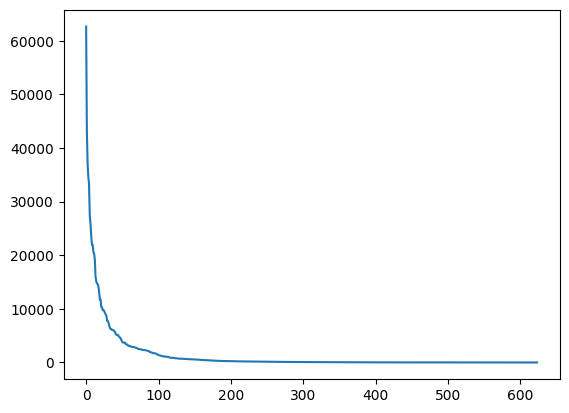

In [110]:
genres_count.sort_values(ascending=False).reset_index(drop=True).plot();

In [111]:
unique_item_tags = genres_count.sort_values(ascending=False)[:20].index
unique_item_tags[:10]

Index(['любовное фэнтези', 'попаданцы', 'современные любовные романы',
       'современные детективы', 'героическое фэнтези', 'боевая фантастика',
       'зарубежные любовные романы', 'боевое фэнтези', 'книги про волшебников',
       'современная русская литература'],
      dtype='object', name='genres')

In [112]:
def filter_genres(genres_list, valid_genres=None):
    if not genres_list:
        return []
    return [genre for genre in genres_list if genre in valid_genres]

In [113]:
%%time
i_features_lfm['features'] = i_features_lfm['genres'].apply(filter_genres, valid_genres=set(unique_item_tags))

CPU times: user 56.2 ms, sys: 0 ns, total: 56.2 ms
Wall time: 66.7 ms


In [114]:
i_features_list = i_features_lfm['features']
i_features_list.loc[TEST_BOOK]

['попаданцы', 'книги про волшебников', 'любовное фэнтези']

#### LightFM Dataset
Посмотрим на то, как в каком формате принимает данные lightfm и как использовать Dataset для конвертации.

LightFM работает со sparse-матрицами, dataset конвертирует данные в coo-формат.
Матрица взаимодействий — это просто матрица размером количество пользователей $\times$ количество объектов.
Матрицы признаков выглядят интереснее.

In [115]:
lfm_dataset = LFMDataset()

In [116]:
lfm_dataset.fit_partial(users=filtered_df['user_id'].unique(), items=filtered_df['item_id'].unique())
lfm_dataset.fit_partial(user_features=unique_user_tags, item_features=unique_item_tags)

In [117]:
user_mapping, item_mapping = lfm_dataset.mapping()[0], lfm_dataset.mapping()[2]

In [118]:
lfm_dataset.mapping()[3]['книги про волшебников']

50990

In [119]:
inv_user_mapping = {value: key for key, value in user_mapping.items()}
inv_item_mapping = {value: key for key, value in item_mapping.items()}

In [133]:
TEST_BOOK_LFM = item_mapping[TEST_BOOK]

#### transform features

In [122]:
lfm_dataset.interactions_shape()

(33875, 50982)

In [123]:
sparse_i_features = lfm_dataset.build_item_features([[row.item_id, row.features] for row in i_features_list.reset_index().itertuples()])
sparse_u_features = lfm_dataset.build_user_features([[row.user_id, row.features] for row in u_features_list.reset_index().itertuples()])

In [124]:
sparse_i_features.shape

(50982, 51002)

In [128]:
sparse_i_features[1]

<1x51002 sparse matrix of type '<class 'numpy.float32'>'
	with 2 stored elements in Compressed Sparse Row format>

In [131]:
i_features_list[TEST_BOOK]

['попаданцы', 'книги про волшебников', 'любовное фэнтези']

In [134]:
sparse_i_features[TEST_BOOK_LFM, :].nonzero(), sparse_i_features[TEST_BOOK_LFM, :].data

((array([0, 0, 0, 0], dtype=int32),
  array([37033, 50982, 50983, 50990], dtype=int32)),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32))

#### transform log

In [135]:
%%time
(interactions, weights) = lfm_dataset.build_interactions([(row.user_id, row.item_id, row.progress) for row in train_by_date.itertuples()])

CPU times: user 1.39 s, sys: 20.7 ms, total: 1.41 s
Wall time: 1.43 s


Посмотрим на содержание матриц interactions и weights: использую матрицу interactions можно легко перейти от explicit feedback к implicit. Будем использовать weights, можете поэкспериментировать с interactions самостоятельно.

In [136]:
interactions.shape, interactions.data

((33875, 50982), array([1, 1, 1, ..., 1, 1, 1], dtype=int32))

Посмотрим на применение модели и воспроизведем подсчет релевантности.

### model training

In [137]:
%%time
lightfm = LightFM(no_components=64, loss='warp', random_state=SEED, user_alpha=1e-5, item_alpha=1e-5)
lightfm.fit(interactions, user_features=sparse_u_features, item_features=sparse_i_features, epochs=100, num_threads=8)

CPU times: user 3min 11s, sys: 245 ms, total: 3min 11s
Wall time: 1min 58s


### predict для одного пользователя

Посмотрим рекомендации для любителя боевой фантастики

In [138]:
pred = lightfm.predict(user_ids=user_mapping[TEST_USER], item_ids=sorted(item_mapping.values()), user_features=sparse_u_features, item_features=sparse_i_features)

In [139]:
ids = np.argpartition(pred, -K)[-K:]
rel = pred[ids]
res = pd.DataFrame(zip(ids, rel), columns=['item_id', 'relevance'])
res['item_id'] = res['item_id'].map(inv_item_mapping)

In [140]:
res.merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
8,43119,-152.138992,Струны волшебства. Книга первая. Страшные сказ...,"Героическое фэнтези,Книги про волшебников",Милена Завойчинская,2018,306
9,50597,-152.509201,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05,490
7,38092,-152.660507,Ведьма-хранительница,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2003,85
6,18971,-152.676025,Верховная Ведьма,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2004,80
5,43572,-152.798920,Чистовик,Научная фантастика,Сергей Лукьяненко,2007,378
3,14267,-152.823303,Зулейха открывает глаза,Современная русская литература,Гузель Яхина,2015,571
4,9325,-152.918671,Ведьмак,"Героическое фэнтези,Зарубежное фэнтези,Боевое ...",Анджей Сапковский,"1993-1997, 1999",82
2,48888,-152.963654,Игра престолов. Часть I,"Зарубежное фэнтези,Боевое фэнтези",Джордж Мартин,1996,149
1,31127,-152.963730,Струны волшебства. Книга вторая. Цветная музык...,"Героическое фэнтези,Книги про волшебников,Любо...",Милена Завойчинская,2018,235
0,43867,-153.005402,Профессия: ведьма,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2003,89


Посчитаем релевантность книги "Магический спецкурс. Первый семестр" для пользователя 4, который предпочитает Героическое фентези.
Используем методы get_item_representations(), get_user_representations(), которые есть у модели LightFM.

In [141]:
item_id_lfm = item_mapping[TEST_BOOK]
user_id_lfm = user_mapping[TEST_USER]

In [142]:
rel = lightfm.predict(user_ids=user_id_lfm, 
                      item_ids=[item_id_lfm], 
                      user_features=sparse_u_features, 
                      item_features=sparse_i_features)[0]
rel

-154.39502

Получили релевантность моделью, проверим, что поняли, как оно работает

Отлично, разобрались с тем, как использовать модели LightFM, давайте попробуем воспроизвести подсчет релевантности. Для этого вернемся к формуле:

$$r_{ui} = <q_u , p_i> + b_u + b_i$$

$$q_u = \sum_{j \in f_u} e^U_j$$
$$ e^U_j = w^U_j  e_j$$ 
$$b_u = \sum_{j \in f_u} b^U_j$$
$$ b^U_j = w^U_j  b_j$$ 
где $q_u, p_i$ - вектора пользователя и объекта, являющиеся суммой векторов их признаков
$b_u, b_i$ - смещения для признаков пользователя и объекта


In [143]:
u_biases, u_vectors = lightfm.get_user_representations()
u_vectors.shape, u_biases.shape

((33883, 64), (33883,))

In [144]:
i_biases, i_vectors =lightfm.get_item_representations()
i_vectors.shape, i_biases.shape

((51002, 64), (51002,))

In [145]:
user_vector = sparse_u_features[user_id_lfm]@u_vectors
item_vector = sparse_i_features[item_id_lfm]@i_vectors
rel_ours = (user_vector@item_vector.T + sparse_u_features[user_id_lfm]@u_biases + sparse_i_features[item_id_lfm]@i_biases).ravel()[0]

In [146]:
assert math.isclose(rel, rel_ours, rel_tol=1e-5)

Все совпало, мы молодцы! Имея вектора пользователей и объектов, мы можем искать похожих, как делали это в SVD.

Обернем в класс, чтобы получить predict и посчитать метрики

In [147]:
from typing import Dict, Iterable
class UserFriendlyLightFM(SVDModel):
    user_mapping: Dict
    item_mapping: Dict
    inv_user_mapping: Dict
    inv_item_mapping: Dict
    lightfm_dataset: LFMDataset
        
    def __init__(self, 
                 user_ids: np.ndarray, 
                 item_ids: np.ndarray,
                 user_tags: Optional[Iterable],
                 item_tags: Optional[Iterable],
                 epochs: int,
                 model: LightFM
                ):
        self.lightfm_dataset = LFMDataset()
        self.lightfm_dataset.fit(users=user_ids, 
                                         items=item_ids,
                                         user_features=user_tags,
                                         item_features=item_tags,
                                        )
        self.user_mapping = self.lightfm_dataset.mapping()[0]
        self.item_mapping = self.lightfm_dataset.mapping()[2]
        self.inv_user_mapping = {value: key for key, value in self.user_mapping.items()}
        self.inv_item_mapping = {value: key for key, value in self.item_mapping.items()}
        self.epochs = epochs
        self.model = model

        
    def _transform_dataset(self, 
                           log: Optional[pd.DataFrame],
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None):
        
        (interactions, weights) = self.lightfm_dataset.build_interactions([(row.user_id, row.item_id, row.progress) for row in log.itertuples()]) if log is not None else (None, None)
        user_features_sparse = self.lightfm_dataset.build_user_features([[row.user_id, row.features] for row in user_features.reset_index().itertuples()]) if user_features is not None else None
        item_features_sparse = self.lightfm_dataset.build_item_features([[row.item_id, row.features] for row in item_features.reset_index().itertuples()]) if item_features is not None else None
        return interactions, weights, user_features_sparse, item_features_sparse
    
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'UserFriendlyLightFM':
        
        interactions, weights, user_features_sparse, item_features_sparse = self._transform_dataset(log, user_features, item_features)
        self.model.fit(interactions, user_features=user_features_sparse, item_features=item_features_sparse, epochs=self.epochs, num_threads=8)
        return self

    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        
        pred = pd.DataFrame(users.map(self.user_mapping).unique(), columns=['user_id'])
        pred.dropna(inplace=True)
        interactions, weights, user_features_sparse, item_features_sparse = self._transform_dataset(None, user_features, item_features)
        
        
        def _get_lfm_pred_all_items(user_id):
            pred_for_all = self.model.predict(user_ids=user_id, item_ids=sorted(self.item_mapping.values()), user_features=user_features_sparse, item_features=item_features_sparse)
            ids = np.argpartition(pred_for_all, -k)[-k:]
            rel = pred_for_all[ids]
            return list(zip(ids, rel))
    
        pred['recs'] = pred['user_id'].apply(_get_lfm_pred_all_items)
        pred = pred.explode('recs')
        self._split_pair(pred)
        pred['item_id'] = pred['item_id'].map(self.inv_item_mapping)
        pred['user_id'] = pred['user_id'].map(self.inv_user_mapping)
        return pred

## LightFM без признаков

In [148]:
lfm = UserFriendlyLightFM(user_ids=filtered_df['user_id'].unique(), 
                             item_ids=filtered_df['item_id'].unique(),
                             user_tags=unique_user_tags,
                             item_tags=unique_item_tags,
                             epochs=100,
                             model=LightFM(no_components=64, loss='warp', random_state=SEED, user_alpha=1e-5, item_alpha=1e-5))

In [149]:
%%time
lfm.fit(log=train_by_date, user_features=None, item_features=None)

CPU times: user 4min 6s, sys: 294 ms, total: 4min 6s
Wall time: 2min 33s


In [150]:
%%time
lfm_pred = lfm.predict(log=train_by_date, users=test_by_date_users, k=K, user_features=None, item_features=None)

CPU times: user 48.9 s, sys: 397 ms, total: 49.3 s
Wall time: 49.7 s


In [171]:
measure(lfm_pred, test_by_date, 'LightFM_rec_64_100_ep', metrics, cov_items=filtered_df['item_id'], surp=surp).sort_values('hit_rate@K', ascending=False)

CPU times: user 1.23 ms, sys: 992 µs, total: 2.22 ms
Wall time: 5.41 ms


,hit_rate@1,hit_rate@K,map@K,ndcg@K,coverage@K,surprisal@K
svd_rec,0.023008,0.112704,0.013908,0.028075,0.029226,0.55263
LightFM_rec_64_100_ep,0.019006,0.107036,0.010328,0.022528,0.131282,0.61082
popular,0.002668,0.023008,0.001435,0.003687,0.000353,0.426938


## LightFM  c признаками

In [172]:
lfm_uf = UserFriendlyLightFM(user_ids=filtered_df['user_id'].unique(), 
                             item_ids=filtered_df['item_id'].unique(),
                             user_tags=unique_user_tags,
                             item_tags=unique_item_tags,
                             epochs=100,
                             model=LightFM(no_components=64, loss='warp', user_alpha=1e-5, item_alpha=1e-5)
                            )

In [173]:
%%time
lfm_uf.fit(log=train_by_date, item_features=i_features_list, user_features=u_features_list)

CPU times: user 3min 14s, sys: 227 ms, total: 3min 15s
Wall time: 1min 58s


In [174]:
%%time
pred_feat = lfm_uf.predict(log=train_by_date, users=test_by_date_users, k=K, user_features=u_features_list, item_features=i_features_list)

CPU times: user 1min 1s, sys: 429 ms, total: 1min 2s
Wall time: 1min 2s


In [176]:
measure(pred_feat, test_by_date, 'LightFM_rec_features_64_400', metrics, cov_items=filtered_df['item_id'], surp=surp).sort_values('hit_rate@K', ascending=False)

,hit_rate@1,hit_rate@K,map@K,ndcg@K,coverage@K,surprisal@K
svd_rec,0.023008,0.112704,0.013908,0.028075,0.029226,0.55263
LightFM_rec_64_100_ep,0.019006,0.107036,0.010328,0.022528,0.131282,0.61082
LightFM_rec_features_64_400,0.010337,0.070023,0.00485,0.012155,0.135636,0.615651
popular,0.002668,0.023008,0.001435,0.003687,0.000353,0.426938


# Двухуровневая модель

- Как разбить данные без лика?
- Сколько кандидатов генерировать и как?
- Какие признаки добавить для обучения модели второго уровня?
- Как переобучать весь ансамбль?

Примеры:
- [Рекомендации в Okko: как заработать сотни миллионов, перемножив пару матриц](https://habr.com/ru/company/okko/blog/454224/)
- [Rekko Challenge — как занять 2-е место в конкурсе по созданию рекомендательных систем](https://habr.com/ru/company/tinkoff/blog/454818/)
- [Дзен-митап: Объяснимые рекомендации](https://www.youtube.com/watch?v=ll-y6I_r_OM&t=357s)
- [Дзен-митап: Next-level recommendations — как сделать модель второго уровня в рекомендациях](https://www.youtube.com/watch?v=4NutBpiIHi0&t=1240s)
    
    

Команда MTS выложила лекцию про двухуровневую архитектуру — довольно понятно, быстро объясняется и с кодом.
Посмотрите [видео](https://ods.ai/tracks/recsys-course2021/blocks/34e6b8d3-5cf0-4ab8-9443-fbc14ad9cf0b) и [код](https://github.com/sharthZ23/your-second-recsys/tree/master/lecture_5).

Чтобы двухуровневая модель стала работать лучше коллаборативных моделей, обученных на полных данных, нужно:
- чтобы данных было достаточно
- подобрать модели первого уровня, дающие хороший recall (много релевантных кандидатов) как для холодных, так и для теплых пользователей
- подумать над задачей и областью и сгенерировать дополнительные признаки. Почитать о том, какие признаки можно генерировать для обучения двухуровневой модели на задачу рекомендаций можно в статьях с решениями конкурсов из раздела про LightFM.

Примеры признаков для MTS библиотеки:
- как давно последний раз читали эту книгу
- доля книг этого автора от общего числа прочтенных
- популярность книги всего/за последнюю неделю/месяц
- вектора пользователей и айтемов из модели 1 уровня
- падает или растет популярность книги за последнее время

Возможность сгенерировать признаки и использовать на первом уровне не одну модель, а несколько, еще ждет вас в лабе/конкурсе.

# Выводы
- мы поговорили про особенности задачи, метрики и разнообразные требования к рекомендательным системам
- получили примеры кода для моделей и подсчета метрик, которые могут быть полезны в лабе и конкурсе
- попробовали SVD, LightFM
- поговорили немного про двухуровневые архитектуры
- поняли, что рекомендательные системы — это не только матричная факторизация. Можно учить нейронки, хотя до сих пор в конкурсах часто побеждает бустинг со сложной генерацией признаков.
- все архитектуры рекомендательных систем уже реализовали и выложили на github до нас, и надо просто найти нужную библиотеку. Например: [NVIDIA-Merlin](https://github.com/NVIDIA-Merlin/Merlin), [MS recommenders](https://github.com/microsoft/recommenders), [RecBole](https://github.com/RUCAIBox/RecBole), [Elliot](https://github.com/sisinflab/elliot), [RePlay](https://github.com/sberbank-ai-lab/RePlay).


### Другие интересные ссылки

Dzen Recommendation system[https://www.youtube.com/watch?v=uP3punJpJno]


[Yandex Music Recommendation System](https://www.youtube.com/watch?v=vkFcmHfIpto)

Meetup series “Дзен-митап” (youtube)

Курсы: MTS. Your first recsys, MTS. Your second recsys, [Курс по рексистемам в МФТИ](https://www.youtube.com/playlist?list=PLk4h7dmY2eYGU9SAGW4CbdgNAjLFT8hG0)

[Репозиторий](https://github.com/monkey0head/recsys_sem)

Делайте pull request-ы, чтобы улучшить этот семинар)

Автор:
@monkey_head
